# Assignment 2

In [31]:
# Import necessary packages
import tarfile
import os
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import locale
import matplotlib.pyplot as plt
from pandas.plotting import table
import re 
from pathlib import Path
from tqdm import tqdm

In [ ]:
# Extract HTML files from tar file
file_path = "kungalv_slutpriser.tar.gz"

if file_path.endswith("tar.gz"):
    tar = tarfile.open(file_path, "r:gz")
    tar.extractall()
    tar.close()
elif file_path.endswith("tar"):
    tar = tarfile.open(file_path, "r:")
    tar.extractall()
    tar.close()

In [2]:
# Helper Functions
# Convert Swedish date to datetime object string
def clean_date(date):
    locale.setlocale(locale.LC_ALL, 'sv_SE')
    datetime_object = datetime.strptime(date, '%d %B %Y')
    return datetime_object.strftime("%Y-%m-%d")

In [3]:
# Listify all html files from a given root
def get_all_html_files(root_path):
    return Path(root_path).glob("**/*.html")

# Set root folder path
html_root = Path("./kungalv_slutpriser/") 

# Empty global list to store data
listing_elements = []

# Looping through each HTML file and scraping to create a database of listings
for html_file in tqdm(list(get_all_html_files(html_root)), desc='Pages Done'):
    with open(html_file) as fp:
        soup = BeautifulSoup(fp, 'html.parser')

    # find all listings on the HTML page
    listings = soup.findAll('li', class_ = 'sold-results__normal-hit')
    

    for listing in listings:
        listing_soup = BeautifulSoup(str(listing), 'html.parser')
        # Extract and clean house area information
        area = listing_soup.find('div', {'class' : 'sold-property-listing__subheading sold-property-listing__area'}).text.strip()
        area = re.sub(r'\s', ' ', area.strip())
        arealist = re.findall(r'\d+', area)

        if len(arealist) == 3:
            boarea = int(arealist[0])
            biarea = int(arealist[1])
            rooms = int(arealist[2])
            livingarea = boarea+biarea
        elif len(arealist) == 2:
            livingarea = int(arealist[0])
            rooms = int(arealist[1])

        # Extract and clean date information
        date = listing_soup.find('span', {'class' : 'hcl-label hcl-label--state hcl-label--sold-at'}).text.strip()
        match = re.search(r'\d', date)  # Search for the first number
        date_of_sale = clean_date((date[match.start():]))
        # Extract address information
        address = listing_soup.find('h2', {'class' : 'sold-property-listing__heading qa-selling-price-title hcl-card__title'}).text.strip()
        # Extract and clean location information 
        location = listing_soup.find('div', {'class' : 'sold-property-listing__location'}).text
        location = re.sub(r'\s+', ' ', location.split("VillaVilla")[1].strip())
        # DO WE NEED THIS?
        listingarea = listing_soup.find('div', {'class' : 'sold-property-listing__subheading sold-property-listing__area'}).text.strip()
        # Plot area extraction
        plotarea = listing_soup.find('div', {'class' : 'sold-property-listing__land-area'})
        if plotarea == None:
            plotarea = None
        else:
            plotarea = int("".join(map(str,re.findall(r'\b\d+\b', plotarea.text.strip()))))
        # Closing price extraction and cleaning
        closingprice = listing_soup.find('span',{'class' : 'hcl-text hcl-text--medium'}).text.strip()
        closingprice = int("".join(map(str,re.findall(r'\b\d+\b', closingprice))))
        
        # Append the attributes for each listing to a list
        listing_info = [date_of_sale, address, location, livingarea, rooms, plotarea, closingprice]
        # Append the list of attributes to the overall list of listings
        listing_elements.append(listing_info)    
    
# Creating dataframe with scraped data
df = pd.DataFrame(listing_elements, columns=(('date_of_sale', 'address','location','livingarea','rooms','plotarea','closingprice')))
df


Pages Done: 100%|██████████| 40/40 [00:11<00:00,  3.36it/s]


,date_of_sale,address,location,livingarea,rooms,plotarea,closingprice
0,2017-11-23,Sjöhåla 580,"Kovikshamn, Kungälvs kommun",181,5,1068.0,3100000
1,2017-11-18,Galeasgatan 15,"Kungälv, Kungälvs kommun",167,5,610.0,3850000
2,2017-11-17,Västerhöjdsvägen 36,"Kärna, Kungälvs kommun",107,5,258.0,4000000
3,2017-11-16,Gråstensvägen 19,"Kode Halltorp, Kungälvs kommun",94,5,1197.0,3200000
4,2017-11-16,Hägnan 135,"KAREBY, Kungälvs kommun",235,6,104335.0,8800000
...,...,...,...,...,...,...,...
1968,2016-04-14,Olvonvägen 71,"Kungälv - Romelanda, Kungälvs kommun",230,6,2056.0,4725000
1969,2016-04-14,Rättarevägen 16,"Ytterby, Kungälvs kommun",227,6,732.0,4300000
1970,2016-04-12,Ametistvägen 11,"Kode, Kungälvs kommun",107,4,806.0,2850000
1971,2016-04-09,Rådalsvägen 25 Havsutsikt,"Aröd, Kungälvs kommun",88,3,1462.0,2995000


In [ ]:
# Export to CSV
df.to_csv("problem1.csv")

In [41]:
# Problem 2
#create a new dataframe which only contains listings sold 2022
df['date_of_sale'] = pd.to_datetime(df['date_of_sale'])
df_new = df[df['date_of_sale'].dt.year == 2022]
df_new.sort_values('closingprice', axis=0, ascending=True, inplace=True)
df_new.reset_index(inplace=True)
df_new

/var/folders/w4/480s5y550tj_ptr0wg8vn_6m0000gn/T/ipykernel_10188/793061030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.sort_values('closingprice', axis=0, ascending=True, inplace=True)


,index,date_of_sale,address,location,livingarea,rooms,plotarea,closingprice
0,1745,2022-08-29,Hammarhöjden 700,"Kode, Kungälvs kommun",75,4,1123.0,1650000
1,1574,2022-06-21,Duvesjön 351,"Romelanda, Kungälvs kommun",85,2,2418.0,1750000
2,1752,2022-08-12,Råckeröd 180,"Kärna, Kungälvs kommun",90,4,3183.0,2050000
3,1723,2022-09-29,Norrmannebo 110,"Romelanda, Kungälvs kommun",99,3,1720.0,2100000
4,1604,2022-05-16,Ulvesund 403,"Ytterby, Kungälvs kommun",227,7,287.0,2400000
...,...,...,...,...,...,...,...,...
185,232,2022-03-04,Västra gatan 31,"Gamla Staden, Kungälvs kommun",262,9,636.0,8800000
186,1749,2022-08-24,Korsgatan 3,"Marstrand, Kungälvs kommun",146,4,494.0,9200000
187,1607,2022-05-14,Fredrik Bagges gata 9,"Koön, Marstrand, Kungälvs kommun",135,6,979.0,9500000
188,160,2022-01-07,Mariebergsliden 5,"Öster, Kungälvs kommun",368,7,589.0,10000000


In [42]:
# Do the five-number summary

#round the closinprice numbers to million kr
df_new['closingprice'] = df_new['closingprice'].div(1000000).round(2)




/var/folders/w4/480s5y550tj_ptr0wg8vn_6m0000gn/T/ipykernel_10188/3205219461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['closingprice'] = df_new['closingprice'].div(1000000).round(2)


count    190.000000
mean       5.076421
std        1.557366
min        1.650000
25%        4.012500
50%        5.000000
75%        5.795000
max       10.500000
Name: closingprice, dtype: float64

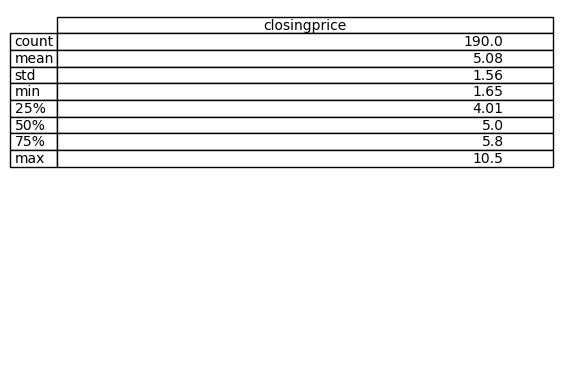

In [49]:

#show 5-number summary
desc = df_new['closingprice'].describe().round(2)

desc

#create a subplot without frame
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, desc,loc='upper right')
